# Tracking Sensor Bias

We want to compute the joint posterior over sensors' biases in a 2-D tracking setting.

In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.optim import Adam

import pyro
import pyro.distributions as dist

import funsor
import funsor.pyro
import funsor.distributions as f_dist
import funsor.ops as ops
from funsor.pyro.convert import dist_to_funsor, mvn_to_funsor, matrix_and_mvn_to_funsor, tensor_to_funsor
from funsor.interpreter import interpretation, reinterpret
from funsor.optimizer import apply_optimizer
from funsor.terms import lazy, eager_or_die, eager
from funsor.domains import bint, reals
from funsor.torch import Tensor, Variable
from funsor.gaussian import Gaussian
from funsor.sum_product import sequential_sum_product

import matplotlib.pyplot as plt

Simulate some synthetic data:

In [2]:
num_sensors = 5
num_frames = 100

# simulate biased sensors
sensors  = []
for _ in range(num_sensors):
    bias = 0.5 * torch.randn(2)
    sensors.append(bias)

# simulate a single track
# TODO heterogeneous time
partial_obs = []
z = 10 * torch.rand(2)  # initial state
v = 2 * torch.randn(2)  # velocity
for t in range(num_frames):
    # Advance latent state.
    z += v + 0.1 * torch.randn(2)
#     z.clamp_(min=0, max=10)  # keep in the box
    
    # Observe via a random sensor.
    sensor_id = pyro.sample('id', dist.Categorical(torch.ones(num_sensors)))
    x = z - sensors[sensor_id]
    partial_obs.append({"sensor_id": sensor_id, "x": x})
    
    
# simulate all sensor observations
full_observations = []
z = 10 * torch.rand(2)  # initial state
v = torch.randn(2)  # velocity
for t in range(num_frames):
    # Advance latent state.
    z += v + 0.1 * torch.randn(2)
    x = z.expand([num_sensors, 2]) - torch.stack(sensors)
    full_observations.append(x)
full_observations = torch.stack(full_observations)
assert full_observations.shape == (num_frames, num_sensors, 2)
full_observations = Tensor(full_observations)["time"]

Now let's set up a tracking problem in Funsor. We start by modeling the biases of each sensor.

In [3]:
# TODO transform this to cholesky decomposition
# print(bias_cov.shape)
# bias_cov = bias_cov @ bias_cov.t()
# create a joint Gaussian over biases

# covs = [torch.eye(2, requires_grad=True) for i in range(num_sensors)]
# bias_dist = 0.
# for i in range(num_sensors):
#     bias += funsor.pyro.convert.mvn_to_funsor(
#         dist.MultivariateNormal(torch.zeros(2), covs[i]),
# #         event_dims=("pos",),
# #         real_inputs=OrderedDict([("bias_{}".format(i), reals(2))])
#         real_inputs=OrderedDict([("bias", reals(2))])
#     )(value="bias_{}".format(i))
# bias_dist.__dict__

# we can't write bias_dist as a sum of mvns because affine transformation
# of mvns is not supported yet.  instead we will combine all the sensors
# into a giant tensor
bias_scales = torch.ones(2, requires_grad=True)  # This can be learned

# bias_dist = funsor.pyro.convert.mvn_to_funsor(
#     dist.MultivariateNormal(
#         torch.zeros(num_sensors * 2),
#         bias_scales.expand(num_sensors, 2).reshape(-1).diag_embed()
#     ),
#     real_inputs=OrderedDict([("bias", reals(num_sensors, 2))])
# )
# bias_dist.__dict__

Set up the filter in funsor.

In [4]:
# TODO
# this can be parameterized by a lower dimensional vector 
# to learn a structured transition matrix
# eg a GP with a matern v=3/2 kernel
# see paper for details 

# transition matrix from discretization as in 
# http://webee.technion.ac.il/people/shimkin/Estimation09/ch8_target.pdf
# T = 1.  # timestep
# trans_matrix_noise = torch.randn(1)  # this could be learnable
# trans_dist_cov = torch.tensor([[1./3 * T ** 3, 0.5 * T ** 2],
#                                   [0.5 * T ** 2, T]]) * trans_matrix_noise ** 2
# transition_matrix = torch.randn(2, 2, requires_grad=True)
# transition_matrix = torch.tensor([[1., T],
#                                   [0, 1]])
# state_dim = 10
# obs_noise = torch.eye(10, 10) #+ 0.1 * torch.randn(10, 10)
# trans_noise = torch.eye(state_dim) #+ 0.1 * torch.randn(state_dim)
# obs_noise.requires_grad = True
# trans_noise.requires_grad = True

In [5]:
# class HMM_that_would_work_if_we_had_more_patterns(nn.Module):
#     def __init__(self, num_sensors, track):
#         self.num_sensors = num_sensors
#         bias_dist = funsor.pyro.convert.mvn_to_funsor(
#             dist.MultivariateNormal(
#                 torch.zeros(num_sensors * 2),
#                 bias_scales.expand(num_sensors, 2).reshape(-1).diag_embed()
#             ),
#             real_inputs=OrderedDict([("bias", reals(num_sensors * 2))])
#         )
#         init_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
#         transition_dist = torch.distributions.MultivariateNormal(
#             torch.zeros(2), trans_dist_cov)
#         observation_matrix = torch.eye(2) + 0.2 * torch.randn(2, 2)
#         observation_matrix = (observation_matrix.unsqueeze(1)
#                                                 .expand(2, num_sensors, 2)
#                                                 .reshape(2, num_sensors * 2))
#         # this is the bias for all the sensors
#         # Note sensor_ids is no longer needed because every sensor.
#         # sensor_ids = torch.tensor([frame["sensor_id"] for frame in track])
#         bias = torch.zeros(num_sensors, 2, requires_grad=True)
#         # obs_dist will be flattened out
#         observation_dist = torch.distributions.MultivariateNormal(
#             bias.reshape(num_sensors * 2),
#             torch.eye(num_sensors * 2))

#         self.init = dist_to_funsor(init_dist)(value="state")
#         # inputs are the previous state ``state`` and the next state
#         transition_matrix = torch.randn(2, 2, requires_grad=True)
#         self.trans = matrix_and_mvn_to_funsor(transition_matrix, transition_dist,
#                                               ("time",), "state", "state(time=1)")
#         self.obs = matrix_and_mvn_to_funsor(observation_matrix, observation_dist,
#                                             ("time",), "state(time=1)", "value")
#         super(HMM, self).__init__()
    
#     def forward(self, track):
#         # we add bias to the observation as a global variable
#         # single interleaved track
#         # we expand the data which will be properly indexed by obs
#         data = torch.stack([frame["x"] for frame in track])
#         data = Tensor(data.unsqueeze(1)
#                           .expand(-1, self.num_sensors, 2)
#                           .reshape(-1, self.num_sensors * 2),
#                       OrderedDict(time=bint(len(track))))
# #         print(f"data.output = {data.output}")

#         # incorporate sensor id in the observation by creating
#         # a free variable that has the signature
#         # inputs: bias of shape (num_sensors, 2), sensor_ids
#         # outputs shape 2
#         # This is like a delayed sample statement:
#         #  bias = pyro.sample("bias", bias_dist)
#         bias = Variable("bias", reals(num_sensors * 2))
#         debiased_observations = data + bias
#         # this indexing pattern is not implemented to sub into a Gaussian
#         # https://github.com/pyro-ppl/funsor/pull/220
#         # instead, we can use matrix_and_mvn_to_funsor and index  the proper latents and just 
#         # observe naively

#         with interpretation(eager_or_die):
# #             print(f"obs.inputs['value'] = {self.obs.inputs['value']}")
#             obs = self.obs(value=debiased_observations)

#             logp = self.trans + obs + bias_dist
        
#             # collapse out the time variable
#             # TODO this can only handle homogeneous funsor types
#             logp = sequential_sum_product(ops.logaddexp, ops.add,
#                                           logp, "time", {"state": "state(time=1)"})
#             logp += init
#             # marginalize out remaining latent variables
#             logp = logp.reduce(ops.logaddexp)
            
#         # extract torch.Tensor from funsor
#         assert isinstance(logp, Tensor), logp.pretty()
#         return logp.data

In [6]:
# class HMM_interleaved_track(nn.Module):
#     def __init__(self, num_sensors):
#         super(HMM, self).__init__()
#         self.num_sensors = num_sensors
        
#     def forward(self, track):
#         num_sensors = self.num_sensors
        
#         bias_dist = funsor.pyro.convert.mvn_to_funsor(
#             dist.MultivariateNormal(
#                 torch.zeros(2),
#                 bias_scales.diag_embed()
#             ),
#             real_inputs=OrderedDict([("bias", reals(num_sensors * 2))])
#         )
#         init_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
#         transition_dist = torch.distributions.MultivariateNormal(
#             torch.zeros(2), trans_dist_cov)
#         observation_matrix = torch.eye(2) + 0.2 * torch.randn(2, 2)
#         # this is the bias for all the sensors
#         # Note sensor_ids is no longer needed because every sensor is observed
#         sensor_ids = torch.tensor([frame["sensor_id"] for frame in track])
#         bias = torch.zeros(num_sensors, 2, requires_grad=True)[sensor_ids]
#         # obs_dist will be flattened out
#         observation_dist = torch.distributions.MultivariateNormal(
#             bias,
#             torch.eye(num_sensors * 2))

#         self.init = dist_to_funsor(init_dist)(value="state")
#         # inputs are the previous state ``state`` and the next state
#         transition_matrix = torch.randn(2, 2, requires_grad=True)
#         self.trans = matrix_and_mvn_to_funsor(transition_matrix, transition_dist,
#                                               ("time",), "state", "state(time=1)")
        
#         # This is what we want
#         # self.obs = matrix_and_mvn_to_funsor(observation_matrix, observation_dist,
#         #                                     ("time",), "state(time=1)", "value")
#         # but instead we will manually insert a bias term into obs.
#         bias_matrix = torch.eye(num_sensors * 2)
#         obs_and_bias_matrix = torch.cat((observation_matrix, bias_matrix))
#         obs = matrix_and_mvn_to_funsor(obs_and_bias_matrix, observation_dist,
#                                        ("time",), "state_and_bias", "value")
        
#         # HACK to replace state_and_bias with two variables.
#         assert (not obs.deltas and
#                 isinstance(obs.discrete, Tensor) and
#                 isinstance(obs.gaussian, Gaussian))
#         inputs = OrderedDict()
#         for k, d in obs.gaussian.inputs.items():
#           if k == "state_and_bias":
#             assert d == reals(2 + num_sensors * 2), d
#             inputs["state(time=1)"] = reals(2)
#             inputs["bias"] = reals(num_sensors * 2)
#           else:
#             inputs[k] = d
#         g = obs.gaussian
#         self.obs = obs.discrete + Gaussian(g.info_vec, g.precision, inputs)
    
#         # we add bias to the observation as a global variable
#         data = torch.stack([frame["x"] for frame in track])
#         assert isinstance(track, list)
#         data = Tensor(data.unsqueeze(1)
#                           .expand(-1, self.num_sensors, 2)
#                           .reshape(-1, self.num_sensors * 2),
#                       OrderedDict(time=bint(len(track))))


#         with interpretation(eager_or_die):
#             logp = self.obs(value=data)
#             logp += bias_dist + self.trans
        
#             # collapse out the time variable
#             # TODO this can only handle homogeneous funsor types
#             logp = sequential_sum_product(ops.logaddexp, ops.add,
#                                           logp, "time", {"state": "state(time=1)"})
#             logp += self.init
#             # marginalize out remaining latent variables
#             logp = logp.reduce(ops.logaddexp)
            
#         # extract torch.Tensor from funsor
#         assert isinstance(logp, Tensor), logp.pretty()
#         return logp.data

In [7]:
# class HMM_without_affine(nn.Module):
#     def __init__(self, num_sensors):
#         super(HMM_without_affine, self).__init__()
#         self.num_sensors = num_sensors
        
#     def forward(self, track):
#         num_sensors = self.num_sensors
        
#         bias_dist = funsor.pyro.convert.mvn_to_funsor(
#             dist.MultivariateNormal(
#                 torch.zeros(num_sensors * 2),
#                 bias_scales.expand(num_sensors, 2).reshape(-1).diag_embed()
#             ),
#             real_inputs=OrderedDict([("bias", reals(num_sensors * 2))])
#         )
#         init_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
#         transition_dist = torch.distributions.MultivariateNormal(
#             torch.zeros(2), trans_dist_cov)
#         observation_matrix = torch.eye(2) + 0.2 * torch.randn(2, 2)
#         observation_matrix = (observation_matrix.unsqueeze(1)
#                                                 .expand(2, num_sensors, 2)
#                                                 .reshape(2, num_sensors * 2))
#         # this is the bias for all the sensors
#         # Note sensor_ids is no longer needed because every sensor is observed
#         # sensor_ids = torch.tensor([frame["sensor_id"] for frame in track])
#         bias = torch.zeros(num_sensors * 2, requires_grad=True)
#         # obs_dist will be flattened out
#         observation_dist = torch.distributions.MultivariateNormal(
#             bias,
#             torch.eye(num_sensors * 2))

#         self.init = dist_to_funsor(init_dist)(value="state")
#         # inputs are the previous state ``state`` and the next state
#         transition_matrix = torch.randn(2, 2, requires_grad=True)
#         self.trans = matrix_and_mvn_to_funsor(transition_matrix, transition_dist,
#                                               ("time",), "state", "state(time=1)")
        
#         # This is what we want
#         # self.obs = matrix_and_mvn_to_funsor(observation_matrix, observation_dist,
#         #                                     ("time",), "state(time=1)", "value")
#         # but instead we will manually insert a bias term into obs.
#         bias_matrix = torch.eye(num_sensors * 2)
#         obs_and_bias_matrix = torch.cat((observation_matrix, bias_matrix))
#         obs = matrix_and_mvn_to_funsor(obs_and_bias_matrix, observation_dist,
#                                        ("time",), "state_and_bias", "value")
        
#         # HACK to replace state_and_bias with two variables.
# #         assert (not obs.deltas and
# #                 isinstance(obs.discrete, Tensor) and
# #                 isinstance(obs.gaussian, Gaussian))
#         inputs = OrderedDict()
#         for k, d in obs.gaussian.inputs.items():
#           if k == "state_and_bias":
#             assert d == reals(2 + num_sensors * 2), d
#             inputs["state(time=1)"] = reals(2)
#             inputs["bias"] = reals(num_sensors * 2)
#           else:
#             inputs[k] = d
#         g = obs.gaussian
#         self.obs = obs.discrete + Gaussian(g.info_vec, g.precision, inputs)
    
#         # we add bias to the observation as a global variable
# #         data = torch.stack([frame["x"] for frame in track])
# #         data = Tensor(data.unsqueeze(1)
# #                           .expand(-1, self.num_sensors, 2)
# #                           .reshape(-1, self.num_sensors * 2),
# #                       OrderedDict(time=bint(len(track))))
#         assert isinstance(track, Tensor)
#         data = Tensor(track.data.reshape(-1, self.num_sensors * 2),
#                       OrderedDict(time=bint(len(track.data))))

#         with interpretation(eager_or_die):
#             logp = self.obs(value=data)
#             logp += bias_dist + self.trans
        
#             # collapse out the time variable
#             # TODO this can only handle homogeneous funsor types
#             logp = sequential_sum_product(ops.logaddexp, ops.add,
#                                           logp, "time", {"state": "state(time=1)"})
#             logp += self.init
#             # marginalize out remaining latent variables
#             logp = logp.reduce(ops.logaddexp)
            
#         # extract torch.Tensor from funsor
#         assert isinstance(logp, Tensor), logp.pretty()
#         return logp.data

In [26]:
class HMM(nn.Module):
    def __init__(self, num_sensors, state_dim):
        super(HMM, self).__init__()
        self.num_sensors = num_sensors
        self.state_dim = state_dim
        
        # learnable params
        self.bias_scales = bias_scales = nn.Parameter(torch.ones(2))
        obs_noise = torch.eye(10, 10) + 0.1 * torch.randn(10, 10)
        self.trans_noise = nn.Parameter(torch.eye(state_dim))
        self.obs_noise = nn.Parameter(obs_noise)
        
    def forward(self, track):
        num_sensors = self.num_sensors
        state_dim = self.state_dim
        
        # reshape the data
        assert isinstance(track, Tensor)
        data = Tensor(track.data.reshape(-1, self.num_sensors * 2),
                      OrderedDict(time=bint(len(track.data))))
        
        # bias distribution
        bias = Variable('bias', reals(num_sensors * 2))
        bias_dist = dist_to_funsor(
            dist.MultivariateNormal(
                torch.zeros(num_sensors * 2),
                bias_scales.expand(num_sensors, 2).reshape(-1).diag_embed()
            )
        )(value=bias)
        
        # this needs to be a funsor dist
        init_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2) + 0.1 * torch.randn(2))
        self.init = dist_to_funsor(init_dist)(value="state")
        
        # hidden states
        prev = Variable("prev", reals(state_dim))
        curr = Variable("curr", reals(state_dim))
        # inputs are the previous state ``state`` and the next state
        transition_matrix = Tensor(torch.randn(state_dim, state_dim, requires_grad=True))
#         transition_matrix = self.transition_matrix
        self.trans_dist = f_dist.MultivariateNormal(
            loc=Tensor(torch.randn(state_dim)),
            scale_tril=Tensor(self.trans_noise),
            value=curr - prev @ transition_matrix)
        
        
        # observation
        # free variables that have distributions over them
        state = Variable('state', reals(state_dim))
        obs = Variable("obs", reals(10))
        observation_matrix = Tensor(torch.randn(state_dim, 10))
        self.observation_dist = f_dist.MultivariateNormal(
            loc=Tensor(torch.zeros(10)),
            scale_tril=Tensor(self.obs_noise),
            value=state @ observation_matrix + bias - obs  # this takes us from state to biased obs
        )

        with interpretation(eager):
            logp = bias_dist
            logp += self.init
            state_0 = Variable("state_0", reals(state_dim))
            # observation at t=0
            logp += self.observation_dist(state=state_0, obs=data(time=0))
            state_1 = Variable("state_1", reals(state_dim))
            # transition to state at t=1
            logp += self.trans_dist(prev=state_0, curr=state_1)
            # observation at t=1
            logp += self.observation_dist(state=state_1, obs=data(time=1))
            # marginalize out remaining latent variables
            logp = logp.reduce(ops.logaddexp)
            
        # we should get a single scalar Tensor here
        assert isinstance(logp, Tensor) and logp.data.dim() == 0, logp.pretty()
        return logp.data
    
    def predict(self):
        # filter and predict
        return self.observation_dist()

## Inference

Finally we have a result that is a joint Gaussian over the biases.
We can
1. optimize all parameters to maximize `result`
2. estimate the joint distribution over all bias parameters.

In [28]:
num_epochs = 200
# params = [bias_scales, obs_noise, trans_noise]
model = HMM(num_sensors, num_sensors*2)
params_snapshot = []
losses = []
mses = []
optim = Adam(model.parameters(), lr=0.02)

for i in range(num_epochs):
    optim.zero_grad()
    log_prob = model(full_observations)
    loss = -log_prob
    loss.backward()
    losses.append(loss.item())
    if i % 10 == 0:
        params_snapshot.append(bias_scales.data.clone().cpu().numpy())
        print(loss.item())
        mse = full_observations - model.predict()
        mses.append(mse)
    optim.step()

51.36785888671875
55.43386459350586
49.80632781982422
45.355491638183594
40.1198616027832
42.19760513305664
43.62836456298828
43.64277267456055
44.314109802246094
42.20016860961914
43.475685119628906
41.069374084472656
40.86189270019531
38.72650909423828
39.37371063232422
40.39057159423828
38.06660079956055
39.591773986816406
40.68220901489258
37.05362319946289


In [19]:
list(model.named_parameters())

[('trans_noise', Parameter containing:
  tensor([[ 1.0351,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.0533,  0.9992,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [-0.0342, -0.0070,  0.8606,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.1808, -0.0830, -0.0285,  0.9917,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.0912, -0.1662,  0.1426,  0.0379,  1.0898,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000],
          [-0.1088,  0.1289,  0.0339,  0.0840,  0.0337,  0.6253,  0.0000,  0.0000,
            0.0000,  0.0000],
          [ 0.3536, -0.1452,  0.2360, -0.0265, -0.0633,  0.0511,  0.7981,  0.0000,
            0.0000,  0.0000],
          [ 0.2304, -0.0125, -0.0449, -0.1573, -0.0847, -0.0063,  0.1286,  0.7487,
            0.0000,  0.0000],
          [-0.1062,  0.0624, -0.0303, -0.0745,  0.1017, -

In [29]:
[params_snapshot[i] for i in range(10)]

IndexError: list index out of range

Visualize the joint posterior distribution.

### possible plots
1. plot the MSE of the MAP estimates with and without bias (or table)
2. train with and without marginalizing out bias, plot both loss curves
  - plot nll and MSE at each epoch
3. smoothing? would require adjoint algorithm `tests/test_adjoint.py`
4. 

Text(0.5, 0, 'logprob')

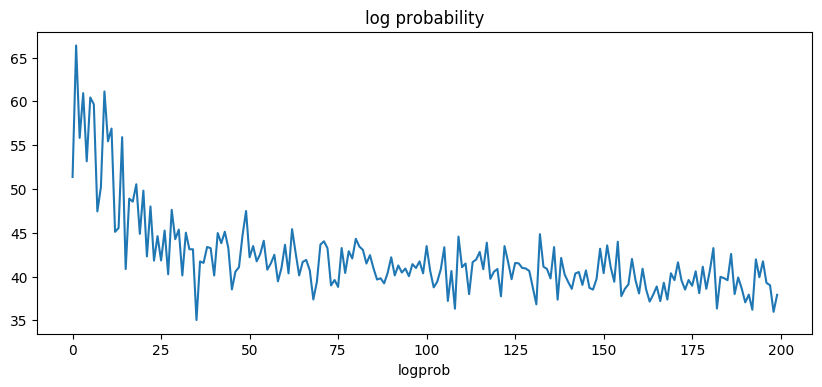

In [30]:
plt.figure(figsize=(10,4), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.title('log probability')
plt.xlabel('Epochs')
plt.xlabel('logprob')

Text(0.5, 0, 'MSE')

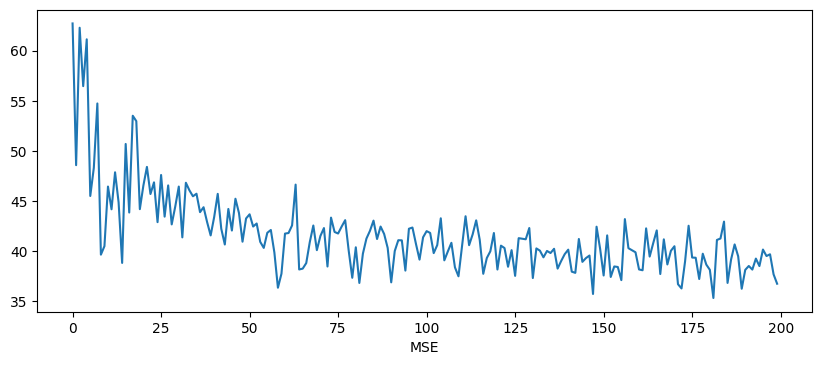

In [12]:
plt.figure(figsize=(10,4), dpi=100).set_facecolor('white')
plt.plot(losses)
# plt.title('M')
plt.xlabel('Epochs')
plt.xlabel('MSE')

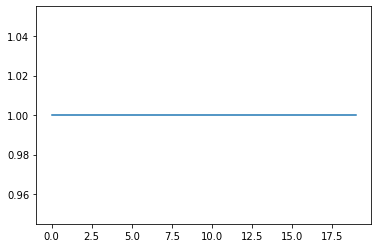

In [13]:
plt.plot([i[0] for i in params_snapshot])

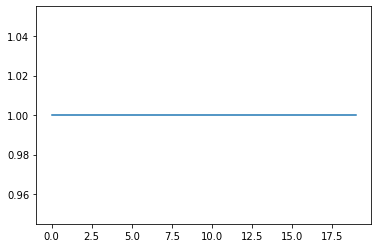

In [14]:
plt.plot([i[1] for i in params_snapshot])

In [15]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
# fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
# sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], shade=True, label="sensoe1")
# axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
# sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], shade=True, label="sensor2")
# axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
# handles, labels = axs[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right');